In [1]:
import zipfile
import os
from PIL import Image
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import re
import random
import glob
import matplotlib.pyplot as plt

Define Paths

In [2]:
images_folder_original = "images_cropped/RGB/"
masks_folder_original = 'gt-masks/segmap3c'
images_folder_BM_removed = 'images_cropped/RGB_inpainted'
#masks_folder_BM_removed = 'unzipped_dataset/cropped_resized_masks/'
test_txt = "train-val-test/test.txt"
validation_txt = "train-val-test/validation.txt"
train_txt = "train-val-test/train.txt"

Read Train, validation, test images according to provided text file 

In [3]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def contrast_normalization_and_enhancement(image):
    # Convert image to float32 before subtracting and dividing
    image = image.astype(np.float32)

    # Calculate the 1st and 99th percentiles of the image data
    min_val = np.percentile(image, 1)
    max_val = np.percentile(image, 99)

    # Stretch the contrast of the image. Any values below min_val or above max_val are set to the min_val or max_val respectively.
    image = np.clip((image - min_val) * 255.0 / (max_val - min_val), 0, 255)

    # Convert back to uint8
    image = image.astype(np.uint8)

    return image

def read_and_preprocess_images(image_dir, mask_dir, txt_file, color_space="HSV", preprocessing=None):
    images = []
    masks = []
    new_size = (256, 256)
    
    with open(txt_file, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            line = line.strip().replace('"', '')
            
            img_path = os.path.join(image_dir, line)
            mask_path = os.path.join(mask_dir, line)
            
            img = cv2.imread(img_path)
            mask = Image.open(mask_path).convert("L").resize(new_size)
            
            if color_space == "HSV":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            else:
                raise ValueError(f"Invalid color space {color_space}")
            
            if preprocessing == "histogram_equalization":
                # Histogram Equalization for HSV should be applied only on the V channel
                img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
                
            elif preprocessing == "clahe":
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                # Apply CLAHE to the V channel
                img[:, :, 2] = clahe.apply(img[:, :, 2])

            elif preprocessing == "contrast_enhancement":
                # Apply contrast enhancement to the V channel
                img[:, :, 2] = contrast_normalization_and_enhancement(img[:, :, 2])

            elif preprocessing == "gamma_correction":
                # Apply gamma correction to the V channel
                img[:, :, 2] = adjust_gamma(img[:, :, 2], gamma=2.0)
                
            img = cv2.resize(img, new_size)
            
            #images.append(cv2.cvtColor(img, cv2.COLOR_HSV2BGR))
            images.append(img)
            masks.append(mask)
            
    return images, masks

# Read the images in different color spaces
test_images_original, test_masks = read_and_preprocess_images(images_folder_original, masks_folder_original, test_txt, color_space="HSV", preprocessing="gamma_correction")
validation_images_original, validation_masks = read_and_preprocess_images(images_folder_original, masks_folder_original, validation_txt, color_space="HSV", preprocessing="gamma_correction")
train_images_original, train_masks = read_and_preprocess_images(images_folder_original, masks_folder_original, train_txt, color_space="HSV", preprocessing="gamma_correction")

test_images_bm_removed, test_masks = read_and_preprocess_images(images_folder_BM_removed, masks_folder_original, test_txt, color_space="HSV", preprocessing="gamma_correction")
validation_images_bm_removed, validation_masks = read_and_preprocess_images(images_folder_BM_removed, masks_folder_original, validation_txt, color_space="HSV", preprocessing="gamma_correction")
train_images_bm_removed, train_masks = read_and_preprocess_images(images_folder_BM_removed, masks_folder_original, train_txt, color_space="HSV", preprocessing="gamma_correction")

print("Test, validation, and train data loaded successfully in HSV color space and gamma_correction applied.")

Test, validation, and train data loaded successfully in HSV color space and gamma_correction applied.


Visualize Some images to check if they are correctly loaded

Train set:


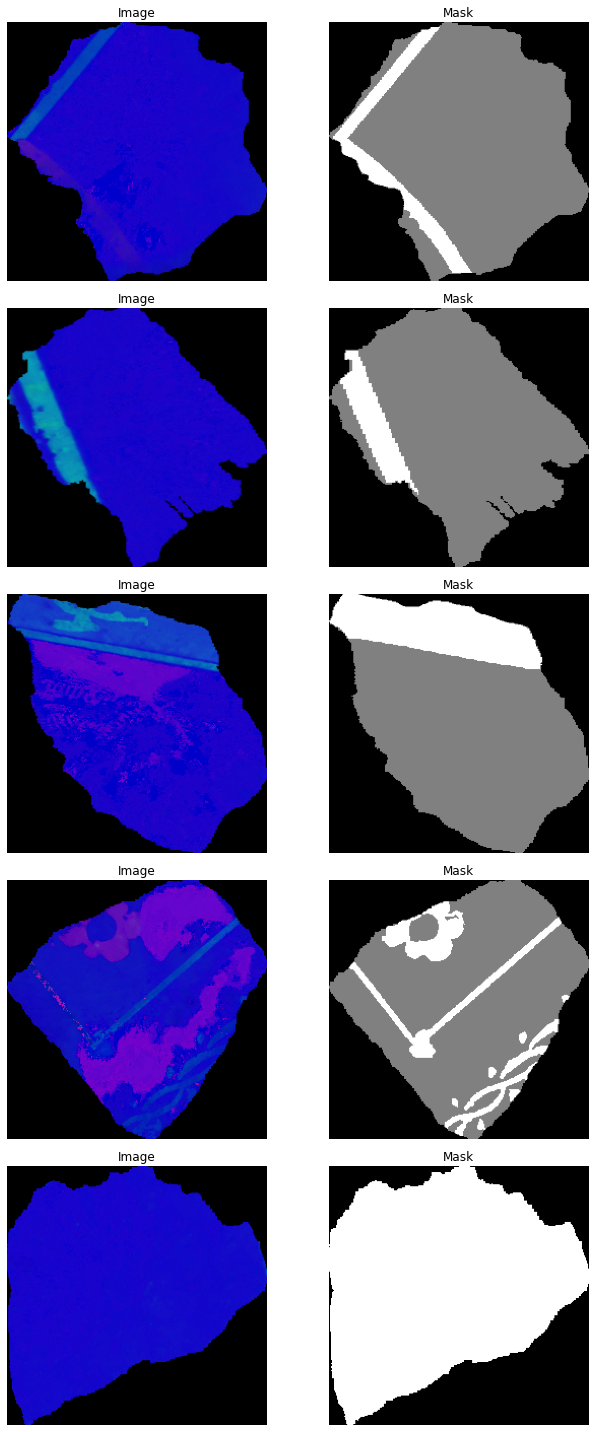

Validation set:


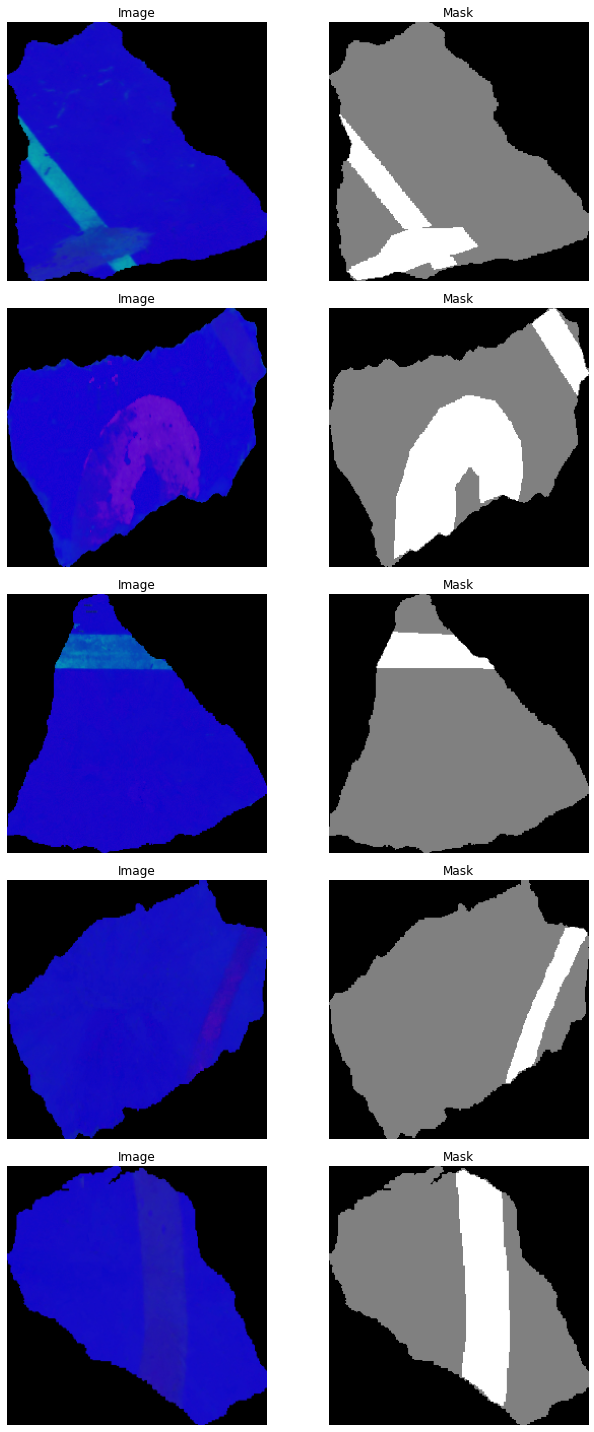

Test set:


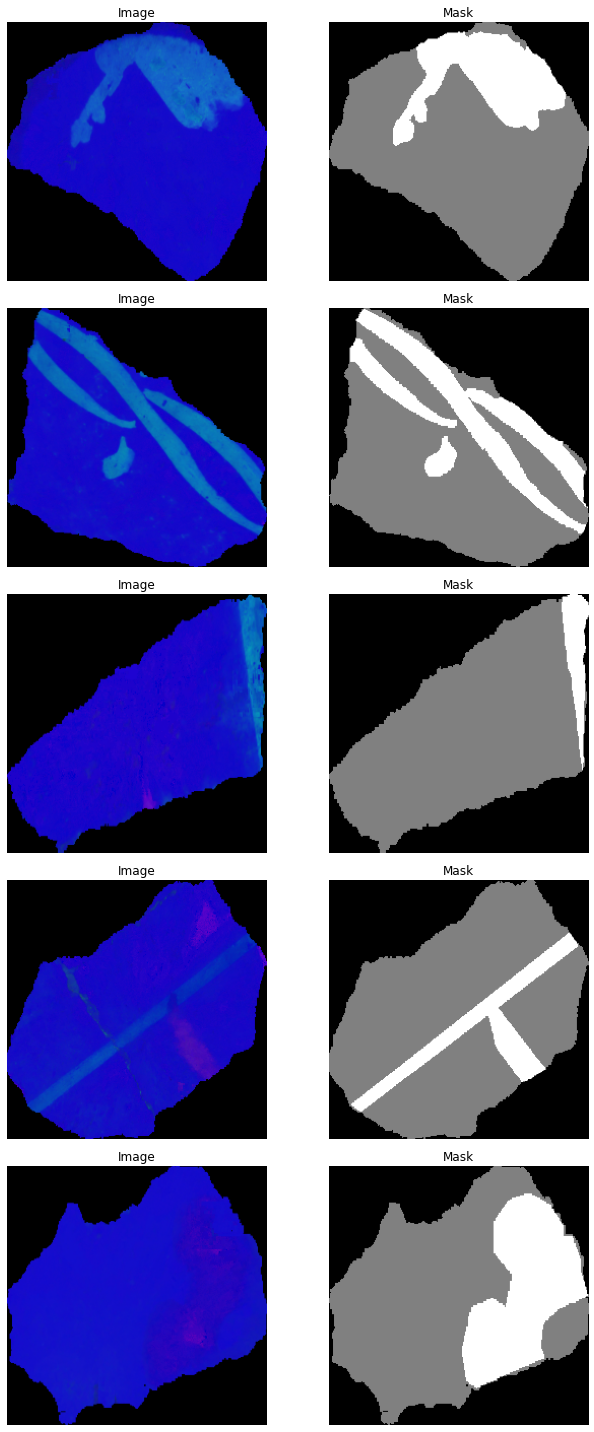

In [4]:
def visualize_data(images, masks, num_samples=5):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, 20))

    for i in range(num_samples):
        img = images[i]
        mask = masks[i]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title("Image")
        ax[i, 0].axis('off')

        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title("Mask")
        ax[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

print("Train set:")
visualize_data(train_images_bm_removed, train_masks)

print("Validation set:")
visualize_data(validation_images_bm_removed, validation_masks)

print("Test set:")
visualize_data(test_images_bm_removed, test_masks)

Check unique pixel values in masks 

In [5]:
def collect_unique_pixel_values(folder_path):
    unique_values_set = set()
    all_files = os.listdir(folder_path)
    ground_truth_files = [file for file in all_files if file.endswith(".png")]

    for file in ground_truth_files:
        file_path = os.path.join(folder_path, file)
        img = Image.open(file_path)
        bitmap_array = np.array(img)

        unique_values = np.unique(bitmap_array)
        unique_values_set.update(unique_values)

    unique_values_array = np.array(list(unique_values_set)).reshape(1, -1)
    return unique_values_array

folder_path = masks_folder_original
unique_pixel_values = collect_unique_pixel_values(folder_path)
print("Unique pixel values across all images:", unique_pixel_values)

Unique pixel values across all images: [[  0   1   2 255]]


Define number of classes

In [6]:
num_classes = 3
num_classes

3

Computing weights

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Convert images to numpy arrays and flatten
all_masks = np.concatenate([np.array(mask).ravel() for mask in train_masks])
unique_classes, counts = np.unique(all_masks, return_counts=True)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=all_masks)
class_weight_dict = dict(zip(unique_classes, class_weights))

print(class_weight_dict)


{0: 0.8624482879253258, 1: 0.7240714286591147, 2: 2.1766055179883392}


Convert masks to categorical

In [8]:
from tensorflow.keras.utils import to_categorical

train_masks_np = np.array([np.array(img) for img in train_masks])
train_masks_one_hot = to_categorical(train_masks_np, num_classes=num_classes)


validation_masks_np = np.array([np.array(img) for img in validation_masks])
validation_masks_one_hot = to_categorical(validation_masks_np, num_classes=num_classes)

test_masks_np = np.array([np.array(img) for img in test_masks])
test_masks_one_hot = to_categorical(test_masks_np, num_classes=num_classes)

Check if it is correctly converted to categorical

Original mask size: (256, 256)
Original mask shape: (256, 256)
One-hot encoded mask shape: (256, 256, 3)


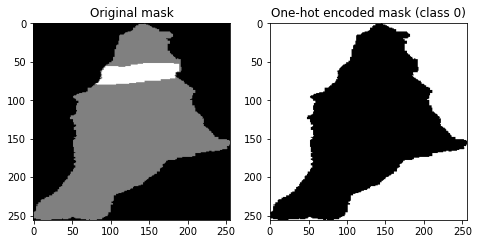

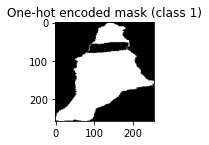

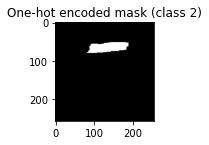

In [9]:
# Choose an index to check
index = 20

# Print the original mask dimensions
print("Original mask size:", train_masks[index].size)

# Convert the PIL Image to numpy array to get its shape
original_mask_np = np.array(train_masks[index])
print("Original mask shape:", original_mask_np.shape)

# Print the one-hot encoded mask shape
print("One-hot encoded mask shape:", train_masks_one_hot[index].shape)

# Plotting...
plt.figure(figsize=(12, 4))

# Display the original mask
plt.subplot(1, 3, 1)
plt.title("Original mask")
plt.imshow(original_mask_np, cmap='gray')

# Display the one-hot encoded mask
for i in range(num_classes):
    plt.subplot(1, 3, 2)
    plt.title(f"One-hot encoded mask (class {i})")
    plt.imshow(train_masks_one_hot[index, :, :, i], cmap='gray')
    plt.show()

Define UNET Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def modified_unet_model(input_size=(256, 256, 3), num_classes = num_classes):
    inputs = tf.keras.Input(input_size)
    
    # Encoder (contracting) path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    
    # Bottleneck
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    

    u8 = UpSampling2D((2, 2))(c5)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def standard_unet_model(input_size=(256, 256, 3), num_classes = num_classes):
    inputs = tf.keras.Input(input_size)
    
    # Encoder (contracting) path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (expanding) path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    #u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    # Create the U-Net model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = model = modified_unet_model(input_size=(256, 256, 3), num_classes=num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [11]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import categorical_crossentropy

class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes):
        super().__init__(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

def weighted_categorical_crossentropy(weights):
    weights = tf.Variable(weights,  dtype='float32')

    def loss(y_true, y_pred):
        # scale predictions so that the class probabilities of each sample sum to 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # calculate loss and weight by class_weights
        loss = y_true * tf.math.log(y_pred) * weights
        # sum over the classes
        loss = -tf.reduce_sum(loss, -1)
        return loss

    return loss

#class_weights = [0.65, 2.81, 0.90]
class_weights = list(class_weight_dict.values())

optimizer = tf.keras.optimizers.Adam(lr=0.0001)    
num_classes = train_masks_one_hot.shape[-1]

# Compile the model
model.compile(optimizer=optimizer,
              loss=weighted_categorical_crossentropy(class_weights),
              metrics=[CustomMeanIoU(num_classes)])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint = ModelCheckpoint('07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma_train_till_converge.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1)
csv_logger = CSVLogger('training_log_07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma_train_till_converge.csv')

train_images_np = np.array([np.array(img) / 255. for img in train_images_original])
validation_images_np = np.array([np.array(img) / 255. for img in validation_images_original])

# Train the model
history = model.fit(
    x=train_images_np,
    y=train_masks_one_hot,
    batch_size=32,
    epochs=200,
    validation_data=(validation_images_np, validation_masks_one_hot),
    callbacks=[checkpoint, early_stopping, csv_logger]
)

Epoch 1/200
11/11 [==============================] - ETA: 0s - loss: 1.0929 - custom_mean_io_u: 0.5000
Epoch 00001: val_loss improved from inf to 1.04477, saving model to 07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma_train_till_converge.h5
11/11 [==============================] - 97s 9s/step - loss: 1.0929 - custom_mean_io_u: 0.5000 - val_loss: 1.0448 - val_custom_mean_io_u: 0.7623
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 1.0601 - custom_mean_io_u: 0.7006
Epoch 00002: val_loss improved from 1.04477 to 0.99678, saving model to 07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma_train_till_converge.h5
11/11 [==============================] - 97s 9s/step - loss: 1.0601 - custom_mean_io_u: 0.7006 - val_loss: 0.9968 - val_custom_mean_io_u: 0.4227
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.9652 - custom_mean_io_u: 0.4123
Epoch 00003: val_loss improved from 0.99678 to 0.82791, saving model to 07_TrainedOriginalImages_

Evaluation on test_set (3 class segmentation)

In [13]:
test_images_np = np.array([np.array(img) for img in test_images_original])
test_masks_np = np.array([np.array(mask) for mask in test_masks_one_hot])
test_loss, test_metric = model.evaluate(test_images_np, test_masks_np, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test mean IoU: {test_metric}')

Test loss: 0.6864020824432373
Test mean IoU: 0.9020183682441711


Evaluation on test set (only for class 2 whoch is the class for patterns) 

In [14]:
class CustomSingleClassMeanIoU(MeanIoU):
    def __init__(self, num_classes, class_index):
        super().__init__(num_classes=num_classes)
        self.class_index = class_index

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        
        # Only consider y_true and y_pred where y_true is class_index
        mask = tf.equal(y_true, self.class_index)
        
        return super().update_state(tf.boolean_mask(y_true, mask), tf.boolean_mask(y_pred, mask), sample_weight)

single_class_metric = CustomSingleClassMeanIoU(num_classes, 2)

test_images_np = np.array([np.array(img) for img in test_images_original])
test_masks_one_hot = to_categorical(np.array([np.array(mask) for mask in test_masks]), num_classes=num_classes)

model.compile(optimizer=optimizer,
              loss=weighted_categorical_crossentropy(class_weights),
              metrics=[single_class_metric])

test_loss, test_single_class_metric = model.evaluate(test_images_np, test_masks_one_hot, verbose=0)

print(f'Test single-class metric (class 2): {test_single_class_metric}')

Test single-class metric (class 2): 0.31398075819015503


Unique pixel values in the true mask: [0. 1.]
Unique pixel values in the predicted mask: [0 1 2]


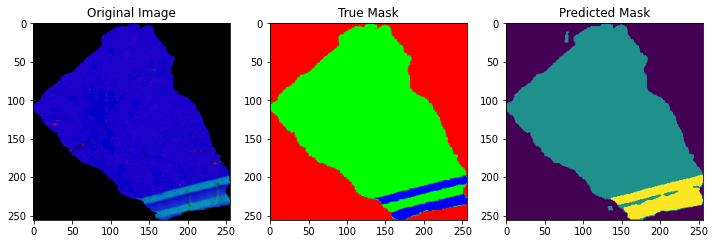

In [16]:
predictions = model.predict(test_images_np)
predictions = np.argmax(predictions, axis=-1)

index = np.random.choice(test_images_np.shape[0])

# Original Image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(test_images_np[index])
plt.title("Original Image")

# True Mask
plt.subplot(1, 3, 2)
plt.imshow(test_masks_np[index])
plt.title("True Mask")
print("Unique pixel values in the true mask:", np.unique(test_masks_np[index]))

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predictions[index])
plt.title("Predicted Mask")
print("Unique pixel values in the predicted mask:", np.unique(predictions[index]))

plt.show()

Load the model

In [22]:
"""
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model

class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes, **kwargs):
        super().__init__(num_classes=num_classes, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

def weighted_categorical_crossentropy(weights):
    weights = tf.Variable(weights,  dtype='float32')

    def loss(y_true, y_pred):
        # scale predictions so that the class probabilities of each sample sum to 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # calculate loss and weight by class_weights
        loss = y_true * tf.math.log(y_pred) * weights
        # sum over the classes
        loss = -tf.reduce_sum(loss, -1)
        return loss

    return loss

def load_custom_model(model_path, class_weights):

    custom_objects = {
        'CustomMeanIoU': CustomMeanIoU,
        'loss': weighted_categorical_crossentropy(class_weights),
    }

    model = load_model(model_path, custom_objects=custom_objects)
    return model

class_weights = list(class_weight_dict.values())
model = load_custom_model('07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma_train_till_converge.h5', class_weights)
"""

Save Predicted masks

In [18]:
def save_predicted_images(images, txt_file, save_dir, model):

    with open(txt_file, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            line = line.strip().replace('"', '')
            img = images[i]
            img = np.expand_dims(img, axis=0)

            pred = model.predict(img)
            pred = pred[0]
            
            pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
            
            pred_gray = np.clip(pred_gray, 0, 255).astype('uint8')

            cv2.imwrite(os.path.join(save_dir, f'prediction_{line}.png'), pred_gray)

save_dir = 'Predicted_masks_07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma__train_till_converge/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_predicted_images(test_images_original, test_txt, save_dir, model)

Save predicted masks as they are plotted

In [19]:
import matplotlib.pyplot as plt

def save_predicted_images(images, txt_file, save_dir, model):

    with open(txt_file, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            line = line.strip().replace('"', '')
            img = images[i]
            img = np.expand_dims(img, axis=0)

            pred = model.predict(img)
            pred = pred[0]
            
            pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
            
            # Normalize to 0-255 range
            pred_gray = (pred_gray - np.min(pred_gray)) / (np.max(pred_gray) - np.min(pred_gray)) * 255

            pred_gray = pred_gray.astype('uint8')

            # Plot and save with matplotlib
            plt.figure()
            plt.imshow(pred_gray, cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(save_dir, f'prediction_{line}.png'), bbox_inches='tight', pad_inches = 0)
            plt.close()

save_dir = 'Predicted_masks_plotted_07_TrainedOriginalImages_HSV_weighted_SimplifiedUNET_Gomma__train_till_converge/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_predicted_images(test_images_original, test_txt, save_dir, model)

Computation of Manual meanIOU on Validation and Test sets

In [17]:
import numpy as np
import tensorflow as tf

validation_images_original = np.array(validation_images_original)
test_images_original = np.array(test_images_original)

print(validation_images_original.shape)
print(test_images_original.shape)

#validation_images_original = np.squeeze(validation_images_original, axis=0)
#test_images_original = np.squeeze(test_images_original, axis=0)

#print(validation_images_original.shape)
#print(test_images_original.shape)

# Generate predictions
validation_pred = model.predict(validation_images_original)
test_pred = model.predict(test_images_original)

# Convert predictions from probabilities to class labels
validation_pred_masks = np.argmax(validation_pred, axis=-1)
test_pred_masks = np.argmax(test_pred, axis=-1)

class_index = 2 
epsilon = 1e-7 #To avoid dividing by zero

# For validation set
print("Validation Set Results:")
validation_manual_iou = []
validation_manual_iou_single_class = []

for pred, gt in zip(validation_pred_masks, validation_masks):
    pred = np.array(pred)
    gt = np.array(gt)

    inters = np.sum((gt == pred))
    union = np.sum(gt >= 0) + np.sum(pred >= 0) - inters 

    iou = inters / (union + epsilon)
    validation_manual_iou.append(iou)

    pred_single_class = (pred == class_index)
    gt_single_class = (gt == class_index)

    inters_single_class = np.sum(pred_single_class & gt_single_class)
    union_single_class = np.sum(pred_single_class | gt_single_class)

    if union_single_class > epsilon:
        iou_single_class = inters_single_class / union_single_class
        validation_manual_iou_single_class.append(iou_single_class)

mean_iou = np.mean(validation_manual_iou)
print(f"3 class Mean IOU: {mean_iou}")

if validation_manual_iou_single_class:
    mean_iou_single_class = np.mean(validation_manual_iou_single_class)
    print(f"Single class Mean IOU: {mean_iou_single_class}")
else:
    print("No instances where both the predicted mask and the ground truth mask are of class 2.")

# For test set
print("Test Set Results:")
test_manual_iou = []
test_manual_iou_single_class = []

for pred, gt in zip(test_pred_masks, test_masks):
    pred = np.array(pred)
    gt = np.array(gt)

    inters = np.sum((gt == pred))
    union = np.sum(gt >= 0) + np.sum(pred >= 0) - inters 

    iou = inters / (union + epsilon)
    test_manual_iou.append(iou)

    pred_single_class = (pred == class_index)
    gt_single_class = (gt == class_index)

    inters_single_class = np.sum(pred_single_class & gt_single_class)
    union_single_class = np.sum(pred_single_class | gt_single_class)

    if union_single_class > epsilon:
        iou_single_class = inters_single_class / union_single_class
        test_manual_iou_single_class.append(iou_single_class)

mean_iou = np.mean(test_manual_iou)
print(f"3 class Mean IOU: {mean_iou}")

if test_manual_iou_single_class:
    mean_iou_single_class = np.mean(test_manual_iou_single_class)
    print(f"Single class Mean IOU: {mean_iou_single_class}")
else:
    print("No instances where both the predicted mask and the ground truth mask are of class 2.")

(40, 256, 256, 3)
(39, 256, 256, 3)
Validation Set Results:
3 class Mean IOU: 0.9295105404141341
Single class Mean IOU: 0.7827793356100315
Test Set Results:
3 class Mean IOU: 0.9236223428617873
Single class Mean IOU: 0.7645633580933737
